## Loading Packages

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import os
from sklearn.metrics import adjusted_rand_score, silhouette_score
import fcsparser

# -------------------------------------------- #

import cellCnn
from cellCnn.utils import loadFCS, ftrans, mkdir_p, get_items
from cellCnn.model import CellCnn
from cellCnn.plotting import plot_results
from sklearn.metrics import roc_auc_score


## Define WDIR and Paths

In [26]:
# Define input and output directories
WDIR = os.path.join(cellCnn.__path__[0], 'examples')
FCS_DATA_PATH = os.path.join(WDIR, 'NK_cell_dataset', 'gated_NK')

## Load Data

In [ ]:
# Load fcs file labels
labels = pd.read_csv(os.path.join(WDIR, 'NK_cell_dataset_main', 'NK_fcs_samples_with_labels.csv'))

# Load FCS data and add labels to the data for every file from the labels file 
def load_fcs_data(fcs_folder):
    data_list = []
    for filename in os.listdir(fcs_folder):
        if filename.endswith(".fcs"):
            path = os.path.join(fcs_folder, filename)
            meta, data = fcsparser.parse(path)
            data.head()
            data['filename'] = filename
            data['label'] = labels[labels['fcs_filename'] == filename]['label'].values[0]
            data_list.append(data)
    return pd.concat(data_list)

data = load_fcs_data(FCS_DATA_PATH)


In [28]:
# count the number of row by label
data['label'].value_counts()

label
0    140007
1    121586
Name: count, dtype: int64

In [29]:
## Filter data by the markers of interest
data_labels = data['label']
markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']

data = data[markers]
data.head()

,CD3,CD27,CD19,CD4,CD8,CD57,2DL1-S1,TRAIL,2DL2-L3-S2,CD16,...,CD94,CD34,CCR7,2DL3,NKG2A,HLA-DR,2DL4,CD56,2DL5,CD25
0,26.322216,-0.910317,-0.638733,-0.601809,178.631790,1.181523,-0.272849,-0.173687,-0.822766,22.600494,...,8.092608,-0.580534,-0.750654,-0.564128,-0.238059,6.143085,-0.882745,-0.022419,-0.613437,-0.320451
1,-0.846317,-0.766500,-0.742613,8.905572,14.484344,-0.909066,-0.731844,-0.473157,-0.277209,31.037779,...,-0.651792,-0.538642,-0.984644,-0.216108,2.301754,102.352203,4.125319,5.322169,-0.826653,-0.329498
2,71.335838,9.887491,-0.332426,69.127586,18.639708,17.665436,-0.879275,0.700263,6.206152,287.275574,...,95.317307,14.912146,-0.802045,-0.421873,46.413567,1.323026,-0.065790,63.151394,2.884951,5.748411
3,2.185232,-0.748874,-0.831503,1.581202,50.228508,-0.547260,-0.852921,-0.136642,-0.257539,204.987488,...,47.851437,-0.464715,-0.404242,-0.136010,-0.912865,11.176067,-0.582589,89.306450,-0.879729,-0.849470
4,7.934325,-0.169841,-0.424672,-0.892627,6.851076,-0.151747,23.062368,-0.636659,4.267561,462.302979,...,3.312762,6.596341,4.092322,48.085941,-0.884382,1.753881,-0.043652,65.164116,-0.073983,-0.079338


## EDA

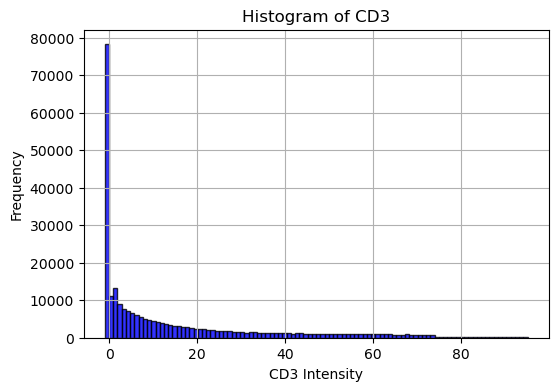

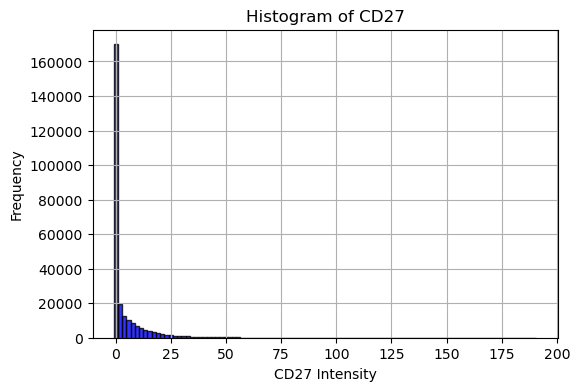

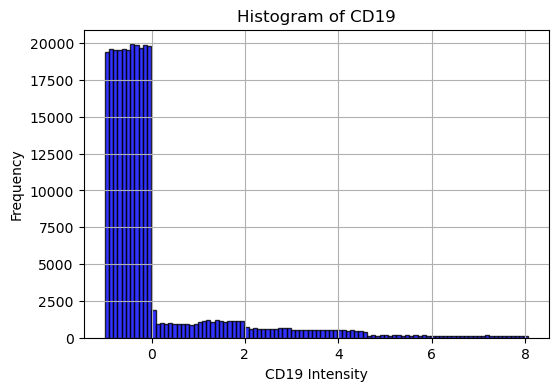

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot histograms for selected markers
select_markers = ['CD3', 'CD27', 'CD19']  # Replace with the marker names in your dataset

def plot_hist(data, select_markers):
    for marker in select_markers:
        plt.figure(figsize=(6, 4))
        plt.hist(data[marker], bins=100, alpha=0.8, color='blue', edgecolor='black')
        plt.title(f'Histogram of {marker}')
        plt.xlabel(f'{marker} Intensity')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

plot_hist(data, select_markers)

In [31]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

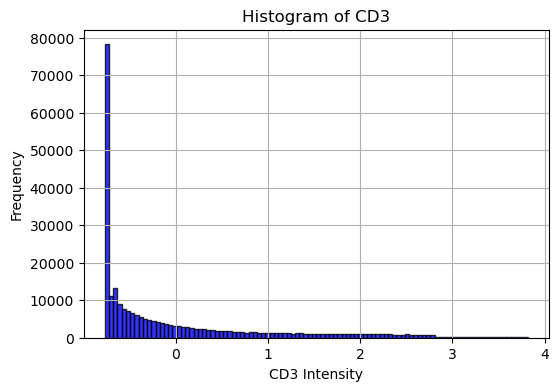

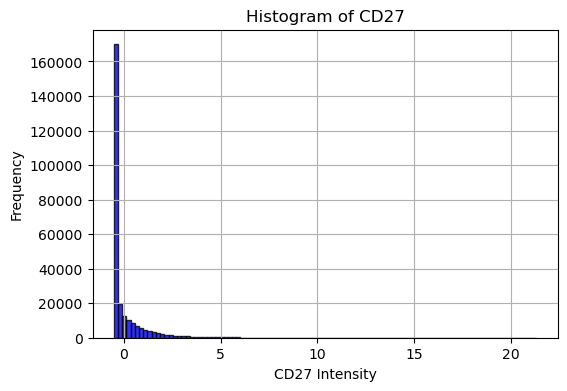

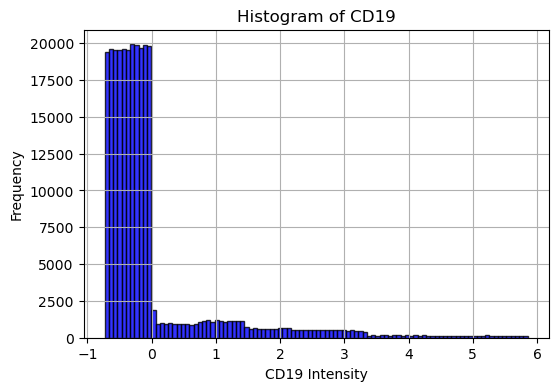

In [32]:
plot_hist(pd.DataFrame(scaled_data, columns=data.columns), select_markers)

### PCA

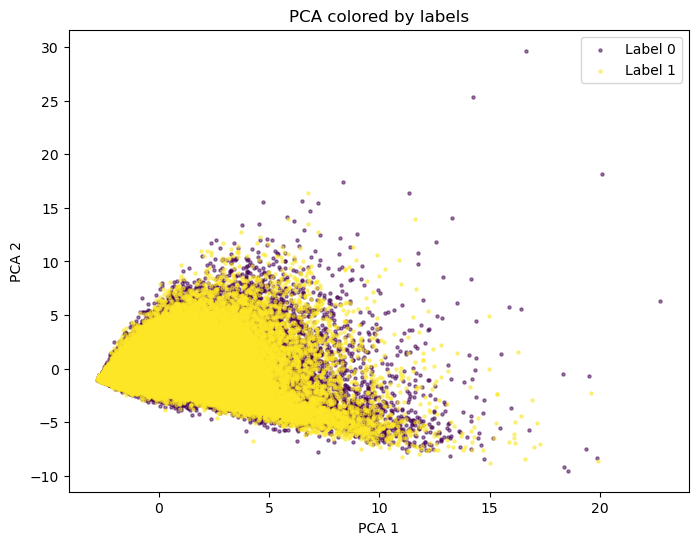

In [33]:
def apply_pca(data, n_components=2):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    return pca_result

# Apply PCA
pca_result = apply_pca(scaled_data)

def plot_pca(pca_result, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(pca_result[idx, 0], pca_result[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.title('PCA colored by labels')
    plt.show()

plot_pca(pca_result, data_labels)

In [34]:
import numpy as np
from scipy.stats import gaussian_kde

# Extract the PCA components
x = pca_result[:, 0]
y = pca_result[:, 1]

# Calculate the point density
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

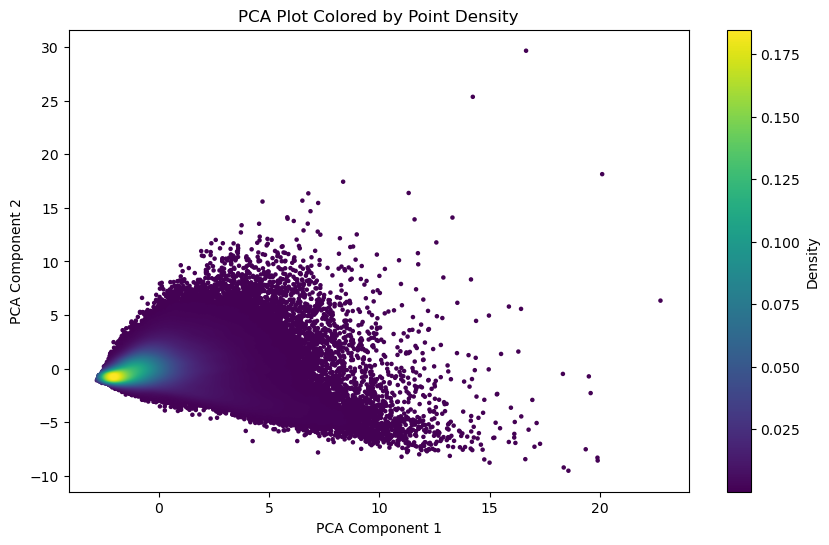

In [38]:
# Sort points by density for better visualization
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=z, cmap='viridis', s=5)
plt.colorbar(label='Density')
plt.title('PCA Plot Colored by Point Density')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

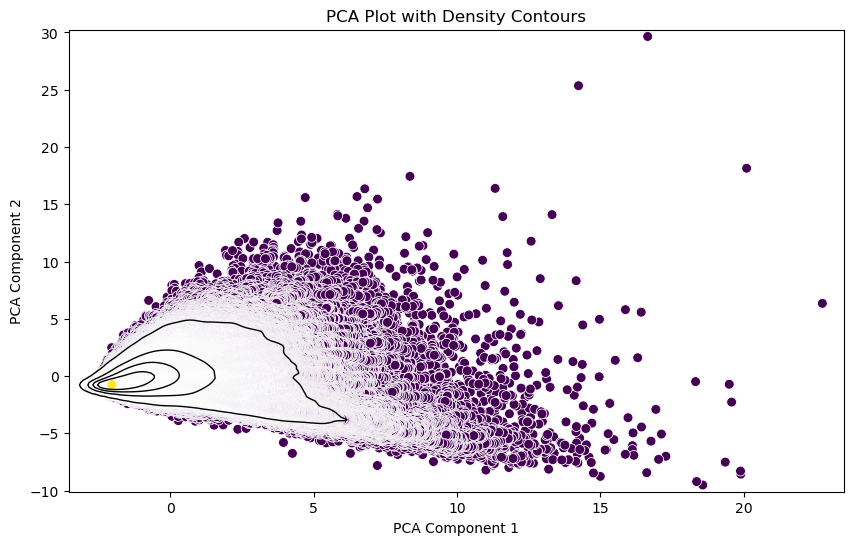

In [42]:
plt.figure(figsize=(10, 6))

# Scatter plot for the points
sns.scatterplot(x=x, y=y, hue=z, palette='viridis', legend=False, s=50)

# Add KDE contours
sns.kdeplot(x=x, y=y, levels=5, color='black', linewidths=1)

plt.title('PCA Plot with Density Contours')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

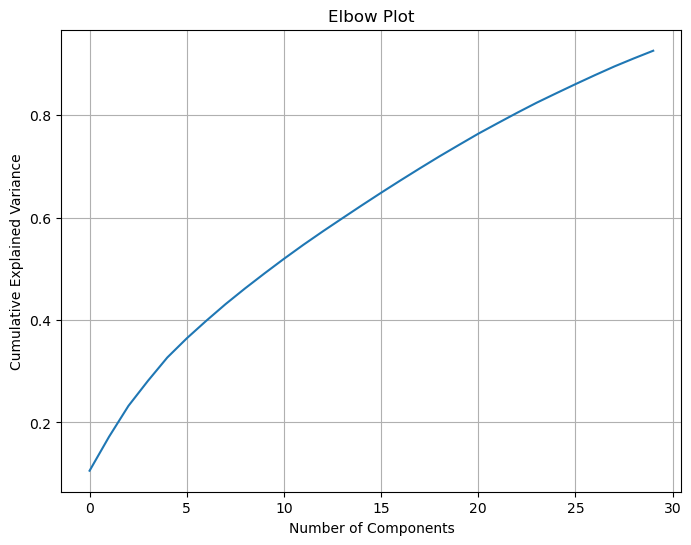

In [46]:
## generate elbow plot to determine the top n components
def plot_elbow(data, n_components=10):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Elbow Plot')
    plt.grid(True)
    plt.show()

plot_elbow(scaled_data, n_components=30)


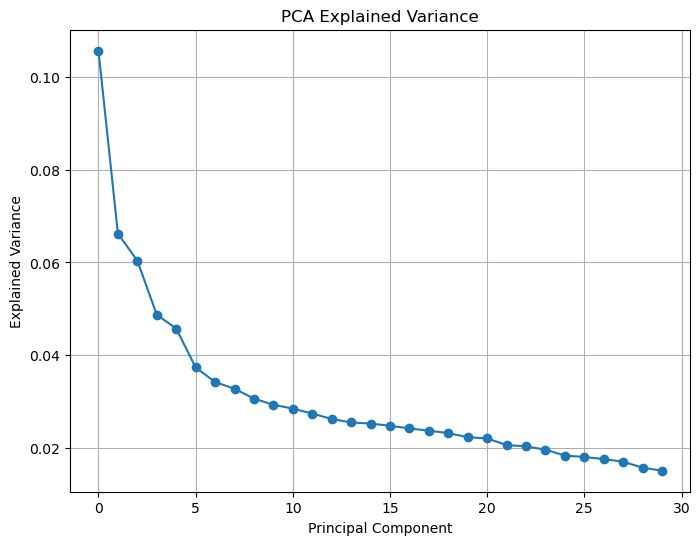

In [48]:
## plot pca variance explained by each component 
def plot_pca_variance(data, n_components=10):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()

plot_pca_variance(scaled_data, n_components=30)

### t-SNE

In [ ]:
def apply_tsne(data, perplexity=30, n_components=2, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

# Apply t-SNE
tsne_result = apply_tsne(pca_result)

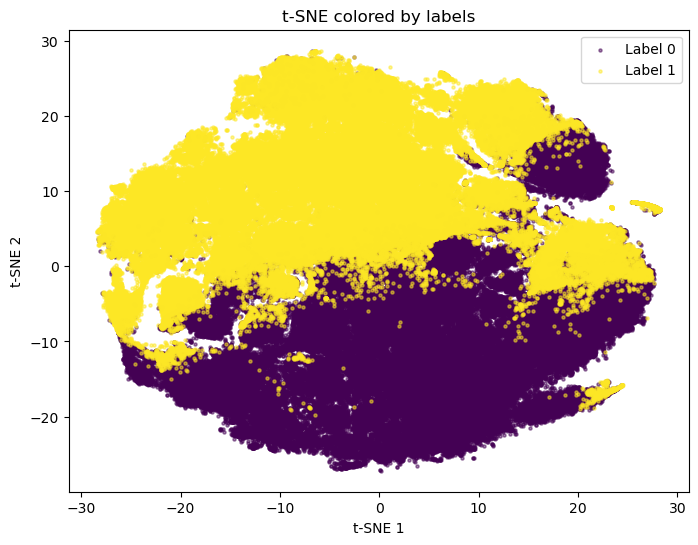

In [99]:
# Visualize t-SNE colored by labels
def plot_tsne(tsne_result, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend()
    plt.title('t-SNE colored by labels')
    plt.show()
plot_tsne(tsne_result, data['label'])

### UMAP

In [40]:
def apply_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_result = reducer.fit_transform(data)
    return umap_result

# Apply UMAP
umap_result = apply_umap(pca_result)

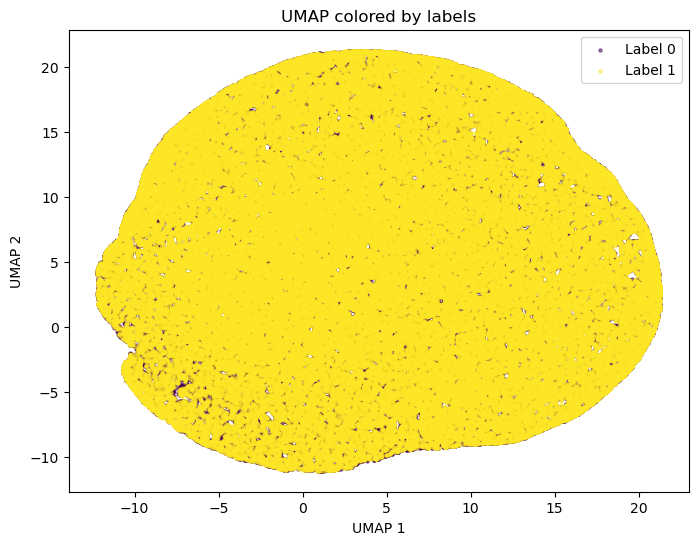

In [41]:
def plot_umap(umap_result, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.title('UMAP colored by labels')
    plt.show()

plot_umap(umap_result, data_labels)

## Comparing the Methods

In [ ]:
# Calculate Silhouette Scores for PCA, t-SNE, and UMAP
def calculate_silhouette(data, labels):
    return silhouette_score(data, labels)

# Using PCA, t-SNE, and UMAP results as labels for silhouette score
pca_silhouette = calculate_silhouette(scaled_data, pca_result[:, 0])
tsne_silhouette = calculate_silhouette(scaled_data, tsne_result[:, 0])
umap_silhouette = calculate_silhouette(scaled_data, umap_result[:, 0])

print(f"Silhouette score for PCA: {pca_silhouette}")
print(f"Silhouette score for t-SNE: {tsne_silhouette}")
print(f"Silhouette score for UMAP: {umap_silhouette}")


## Clustering

### K-means

In [20]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    return kmeans_labels

# Apply KMeans
kmeans_labels = apply_kmeans(scaled_data, n_clusters=2)


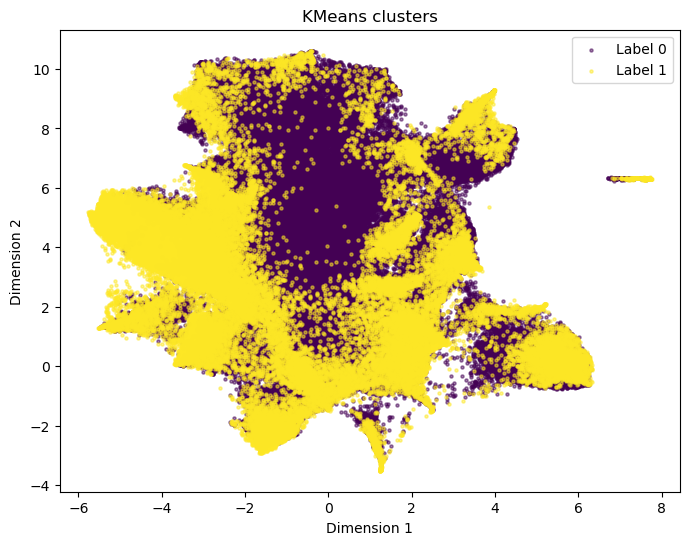

In [22]:
## Plot KMeans clusters
def plot_kmeans(data, labels):
    unique_labels = np.unique(labels)
    colors = plt.get_cmap('viridis', len(unique_labels))

    plt.figure(figsize=(8, 6))

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        plt.scatter(data[idx, 0], data[idx, 1], label=f'Label {lbl}', alpha=0.5, color=colors(i), s=5)

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.title('KMeans clusters')
    plt.show()

plot_kmeans(umap_result, kmeans_labels)

### Hierarchical

In [126]:
from scipy.cluster.hierarchy import linkage, fcluster

def apply_hierarchical(data, n_clusters):
    Z = linkage(data, method='ward')
    hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')
    return hierarchical_labels

# Apply Hierarchical Clustering
hierarchical_labels = apply_hierarchical(scaled_data, n_clusters=2)

### Leiden

In [16]:
import leidenalg as la
import igraph as ig

def apply_leiden(data, n_clusters, knn=15):
    # Convert data to a KNN graph using iGraph
    n_cells = data.shape[0]
    graph = ig.Graph()
    graph.add_vertices(n_cells)

    for i in range(n_cells):
        distances = np.linalg.norm(data - data[i], axis=1)
        neighbors = np.argsort(distances)[1:knn+1]
        for neighbor in neighbors:
            graph.add_edge(i, neighbor)

    # Apply Leiden algorithm
    partition = la.find_partition(graph, la.ModularityVertexPartition)
    leiden_labels = np.array(partition.membership)
    return leiden_labels

# Apply Leiden Clustering
leiden_labels = apply_leiden(scaled_data, n_clusters=2)


KeyboardInterrupt: 

### Comparing the Methods

In [ ]:
true_labels = data_labels

# Adjusted Rand Index
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
hierarchical_ari = adjusted_rand_score(true_labels, hierarchical_labels)
leiden_ari = adjusted_rand_score(true_labels, leiden_labels)

# Silhouette Score
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
leiden_silhouette = silhouette_score(scaled_data, leiden_labels)

# Print Results
print(f"k-means ARI: {kmeans_ari}, Silhouette: {kmeans_silhouette}")
print(f"Hierarchical ARI: {hierarchical_ari}, Silhouette: {hierarchical_silhouette}")
print(f"Leiden ARI: {leiden_ari}, Silhouette: {leiden_silhouette}")


## Comparative Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fcsparser
import umap
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Feature prep

In [9]:
import os
from sklearn.preprocessing import StandardScaler


# Split into features and target (assuming the target is in the 'cell_type' column)
X = scaled_data
y = data_labels # replace with actual label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.6640417439171238


### SVM

In [13]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7399606261587569


### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.7431334696764081
